In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
print(os.listdir('../input'))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['house-prices-advanced-regression-techniques']


In [2]:
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
import scipy.stats as stats
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.cluster import KMeans
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
print ("Data is set!")

Data is set!


In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
numerical_features = train.select_dtypes(include=np.number).drop(columns=['SalePrice','Id'])

In [7]:
numerical_features.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [8]:
object_features = train.select_dtypes(include=object)

In [9]:
object_features.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

<Axes: title={'center': 'Log Normal'}, xlabel='SalePrice'>

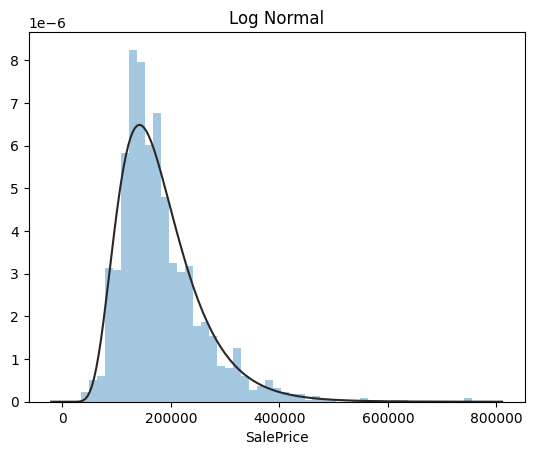

In [10]:
y = train['SalePrice']
plt.figure(1); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

In [11]:
normalization = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[numerical_features.columns])
normal = normal.apply(normalization)
print(not normal.any())

False


In [12]:
numerical_features['SalePrice'] = train['SalePrice']

<Axes: title={'center': 'numerical correlation'}>

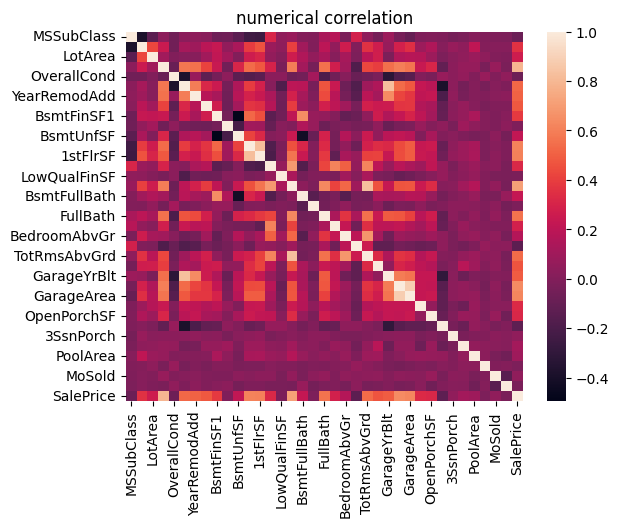

In [13]:
plt.figure(1); plt.title('numerical correlation')
sns.heatmap(numerical_features.corr(), annot=False)

# Models

In [14]:
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

In [15]:
train.reset_index(drop=True, inplace=True)
train['SalePrice'] = np.log1p(train['SalePrice'])
y = train['SalePrice'].reset_index(drop=True)

In [16]:
train = train.drop(['SalePrice'], axis=1)

In [17]:
df_train = train
df_train.shape

(1460, 79)

In [18]:
df_train['GarageYrBlt']

0       2003.0
1       1976.0
2       2001.0
3       1998.0
4       2000.0
         ...  
1455    1999.0
1456    1978.0
1457    1941.0
1458    1950.0
1459    1965.0
Name: GarageYrBlt, Length: 1460, dtype: float64

In [19]:
df_train.drop(['Street'], axis=1)
df_train['LotFrontage'].fillna(math.ceil(df_train['LotFrontage'].mean()), inplace=True)
df_train['MSZoning'].fillna(df_train['MSZoning'].mode()[0], inplace=True)
df_train['Alley'].fillna('None', inplace=True)
df_train['Utilities'].fillna(df_train['Utilities'].mode()[0], inplace=True)
df_train['Exterior1st'].fillna(df_train['Exterior1st'].mode()[0], inplace=True)
df_train['Exterior2nd'].fillna(df_train['Exterior2nd'].mode()[0], inplace=True)
df_train['MasVnrType'].fillna('None', inplace=True)

df_train.loc[df_train['MasVnrType'] == 'None', 'MasVnrArea'] = \
    df_train.loc[df_train['MasVnrType'] == 'None', 'MasVnrArea'].fillna(0)

df_train.loc[df_train['MasVnrType'] != 'None', 'MasVnrArea'] = \
    df_train.loc[df_train['MasVnrType'] != 'None', 'MasVnrArea'].fillna(
        math.ceil(df_train['MasVnrArea'].mean()))

df_train['BsmtQual'].fillna('None', inplace=True)

# When BsmtQual == 'None'
df_train.loc[df_train['BsmtQual'] == 'None', ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']] = \
    df_train.loc[df_train['BsmtQual'] == 'None', ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']].fillna(0)

df_train.loc[df_train['BsmtQual'] == 'None', ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']] = \
    df_train.loc[df_train['BsmtQual'] == 'None', ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']].fillna('None')

# When BsmtQual != 'None'
df_train.loc[df_train['BsmtQual'] != 'None', 'BsmtFinSF1'] = \
    df_train.loc[df_train['BsmtQual'] != 'None', 'BsmtFinSF1'].fillna(
        math.ceil(df_train['BsmtFinSF1'].mean()))

df_train.loc[df_train['BsmtQual'] != 'None', 'BsmtFinSF2'] = \
    df_train.loc[df_train['BsmtQual'] != 'None', 'BsmtFinSF2'].fillna(
        math.ceil(df_train['BsmtFinSF1'].mean()))

df_train.loc[df_train['BsmtQual'] != 'None', 'BsmtCond'] = \
    df_train.loc[df_train['BsmtQual'] != 'None', 'BsmtFinSF2'].fillna(
        df_train['BsmtCond'].mode()[0])

df_train.loc[df_train['BsmtQual'] != 'None', 'BsmtExposure'] = \
    df_train.loc[df_train['BsmtQual'] != 'None', 'BsmtExposure'].fillna(
        df_train['BsmtExposure'].mode()[0])

df_train.loc[df_train['BsmtQual'] != 'None', 'BsmtFinType1'] = \
    df_train.loc[df_train['BsmtQual'] != 'None', 'BsmtFinType1'].fillna(
        df_train['BsmtFinType1'].mode()[0])

df_train.loc[df_train['BsmtQual'] != 'None', 'BsmtFinType2'] = \
    df_train.loc[df_train['BsmtQual'] != 'None', 'BsmtFinType2'].fillna(
        df_train['BsmtFinType2'].mode()[0])

df_train.loc[df_train['BsmtQual'] != 'None', 'BsmtUnfSF'] = \
    df_train.loc[df_train['BsmtQual'] != 'None', 'BsmtUnfSF'].fillna(0)


# df_train['BsmtCond'].fillna('None', inplace=True)
# df_train['BsmtExposure'].fillna('None', inplace=True)
# df_train['BsmtFinType1'].fillna('None', inplace=True)
# df_train['BsmtFinSF1'].fillna(math.ceil(df_train['BsmtFinSF1'].mean()), inplace=True)
# df_train['BsmtFinType2'].fillna('None', inplace=True)
# df_train['BsmtFinSF2'].fillna(math.ceil(df_train['BsmtFinSF2'].mean()), inplace=True)
# df_train['BsmtUnfSF'].fillna(math.ceil(df_train['BsmtUnfSF'].mean()), inplace=True)

df_train.drop(['TotalBsmtSF'], axis=1)
df_train['TotalBsmtSF'] = df_train['BsmtFinSF1'] + df_train['BsmtFinSF2'] + df_train['BsmtUnfSF']
# df_train['TotalBsmtSF'].fillna(math.ceil(df_train['TotalBsmtSF'].mean()), inplace=True)
df_train['Electrical'].fillna(df_train['Electrical'].mode()[0], inplace=True)
df_train['BsmtFullBath'].fillna(math.ceil(df_train['BsmtFullBath'].mean()), inplace=True)
df_train['BsmtHalfBath'].fillna(math.ceil(df_train['BsmtHalfBath'].mean()), inplace=True)
df_train['KitchenQual'].fillna(df_train['KitchenQual'].mode()[0], inplace=True)
df_train['Functional'].fillna(df_train['Functional'].mode()[0], inplace=True)
df_train['GarageType'].fillna('None', inplace=True)

# When GarageType == 'None'
df_train.loc[df_train['GarageType'] == 'None', ['GarageYrBlt', 'GarageCars', 'GarageArea']] = \
    df_train.loc[df_train['GarageType'] == 'None', ['GarageYrBlt', 'GarageCars', 'GarageArea']].fillna(0)

df_train.loc[df_train['GarageType'] == 'None', ['GarageFinish', 'GarageQual', 'GarageCond']] = \
    df_train.loc[df_train['GarageType'] == 'None', ['GarageFinish', 'GarageQual', 'GarageCond']].fillna('None')

# When GarageType != 'None'
df_train.loc[df_train['GarageType'] != 'None', 'GarageYrBlt'] = \
    df_train.loc[df_train['GarageType'] != 'None', 'GarageYrBlt'].fillna(
        math.ceil(df_train['GarageYrBlt'].mean()))

df_train.loc[df_train['GarageType'] != 'None', 'GarageArea'] = \
    df_train.loc[df_train['GarageType'] != 'None', 'GarageArea'].fillna(
        math.ceil(df_train['GarageArea'].mean()))

df_train.loc[df_train['GarageType'] != 'None', 'GarageCars'] = \
    df_train.loc[df_train['GarageType'] != 'None', 'GarageCars'].fillna(
        math.ceil(df_train['GarageCars'].mean()))

df_train.loc[df_train['GarageType'] != 'None', ['GarageFinish', 'GarageQual', 'GarageCond']] = \
    df_train.loc[df_train['GarageType'] != 'None', ['GarageFinish', 'GarageQual', 'GarageCond']].fillna(
        {'GarageFinish': 'None', 'GarageQual': 'None', 'GarageCond': 'None'})
df_train['PoolQC'].fillna('None', inplace=True)
df_train['Fence'].fillna('None', inplace=True)
df_train['MiscFeature'].fillna('None', inplace=True)
df_train['SaleType'].fillna(df_train['SaleType'].mode()[0], inplace=True)
df_train['FireplaceQu'].fillna('None', inplace=True)

In [20]:
df_train.isnull().sum().tolist()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [21]:
df_1 = train[['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']]

In [22]:
df_1

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
0,706,0,150,856
1,978,0,284,1262
2,486,0,434,920
3,216,0,540,756
4,655,0,490,1145
...,...,...,...,...
1455,0,0,953,953
1456,790,163,589,1542
1457,275,0,877,1152
1458,49,1029,0,1078


In [23]:
test.drop(['Street'], axis=1)
test['LotFrontage'].fillna(math.ceil(test['LotFrontage'].mean()), inplace=True)
test['MSZoning'].fillna(test['MSZoning'].mode()[0], inplace=True)
test['Alley'].fillna('None', inplace=True)
test['Utilities'].fillna(test['Utilities'].mode()[0], inplace=True)
test['Exterior1st'].fillna(test['Exterior1st'].mode()[0], inplace=True)
test['Exterior2nd'].fillna(test['Exterior2nd'].mode()[0], inplace=True)
test['MasVnrType'].fillna('None', inplace=True)

test.loc[test['MasVnrType'] == 'None', 'MasVnrArea'] = \
    test.loc[test['MasVnrType'] == 'None', 'MasVnrArea'].fillna(0)

test.loc[test['MasVnrType'] != 'None', 'MasVnrArea'] = \
    test.loc[test['MasVnrType'] != 'None', 'MasVnrArea'].fillna(
        math.ceil(test['MasVnrArea'].mean()))

test['BsmtQual'].fillna('None', inplace=True)

# When BsmtQual == 'None'
test.loc[test['BsmtQual'] == 'None', ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']] = \
    test.loc[test['BsmtQual'] == 'None', ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']].fillna(0)

test.loc[test['BsmtQual'] == 'None', ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']] = \
    test.loc[test['BsmtQual'] == 'None', ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']].fillna('None')

# When BsmtQual != 'None'
test.loc[test['BsmtQual'] != 'None', 'BsmtFinSF1'] = \
    test.loc[test['BsmtQual'] != 'None', 'BsmtFinSF1'].fillna(
        math.ceil(test['BsmtFinSF1'].mean()))

test.loc[test['BsmtQual'] != 'None', 'BsmtFinSF2'] = \
    test.loc[test['BsmtQual'] != 'None', 'BsmtFinSF2'].fillna(
        math.ceil(test['BsmtFinSF1'].mean()))

test.loc[test['BsmtQual'] != 'None', 'BsmtCond'] = \
    test.loc[test['BsmtQual'] != 'None', 'BsmtFinSF2'].fillna(
        test['BsmtCond'].mode()[0])

test.loc[test['BsmtQual'] != 'None', 'BsmtExposure'] = \
    test.loc[test['BsmtQual'] != 'None', 'BsmtExposure'].fillna(
        test['BsmtExposure'].mode()[0])

test.loc[test['BsmtQual'] != 'None', 'BsmtFinType1'] = \
    test.loc[test['BsmtQual'] != 'None', 'BsmtFinType1'].fillna(
        test['BsmtFinType1'].mode()[0])

test.loc[test['BsmtQual'] != 'None', 'BsmtFinType2'] = \
    test.loc[test['BsmtQual'] != 'None', 'BsmtFinType2'].fillna(
        test['BsmtFinType2'].mode()[0])

test.loc[test['BsmtQual'] != 'None', 'BsmtUnfSF'] = \
    test.loc[test['BsmtQual'] != 'None', 'BsmtUnfSF'].fillna(0)

test.drop(['TotalBsmtSF'], axis=1)
test['TotalBsmtSF'] = test['BsmtFinSF1'] + test['BsmtFinSF2'] + test['BsmtUnfSF']
test['Electrical'].fillna(test['Electrical'].mode()[0], inplace=True)
test['BsmtFullBath'].fillna(math.ceil(test['BsmtFullBath'].mean()), inplace=True)
test['BsmtHalfBath'].fillna(math.ceil(test['BsmtHalfBath'].mean()), inplace=True)
test['KitchenQual'].fillna(test['KitchenQual'].mode()[0], inplace=True)
test['Functional'].fillna(test['Functional'].mode()[0], inplace=True)
test['GarageType'].fillna('None', inplace=True)

# When GarageType == 'None'
test.loc[test['GarageType'] == 'None', ['GarageYrBlt', 'GarageCars', 'GarageArea']] = \
    test.loc[test['GarageType'] == 'None', ['GarageYrBlt', 'GarageCars', 'GarageArea']].fillna(0)

test.loc[test['GarageType'] == 'None', ['GarageFinish', 'GarageQual', 'GarageCond']] = \
    test.loc[test['GarageType'] == 'None', ['GarageFinish', 'GarageQual', 'GarageCond']].fillna('None')

# When GarageType != 'None'
test.loc[test['GarageType'] != 'None', 'GarageYrBlt'] = \
    test.loc[test['GarageType'] != 'None', 'GarageYrBlt'].fillna(
        math.ceil(test['GarageYrBlt'].mean()))

test.loc[test['GarageType'] != 'None', 'GarageArea'] = \
    test.loc[test['GarageType'] != 'None', 'GarageArea'].fillna(
        math.ceil(test['GarageArea'].mean()))

test.loc[test['GarageType'] != 'None', 'GarageCars'] = \
    test.loc[test['GarageType'] != 'None', 'GarageCars'].fillna(
        math.ceil(test['GarageCars'].mean()))

test.loc[test['GarageType'] != 'None', ['GarageFinish', 'GarageQual', 'GarageCond']] = \
    test.loc[test['GarageType'] != 'None', ['GarageFinish', 'GarageQual', 'GarageCond']].fillna(
        {'GarageFinish': 'None', 'GarageQual': 'None', 'GarageCond': 'None'})
test['PoolQC'].fillna('None', inplace=True)
test['Fence'].fillna('None', inplace=True)
test['MiscFeature'].fillna('None', inplace=True)
test['SaleType'].fillna(test['SaleType'].mode()[0], inplace=True)
test['FireplaceQu'].fillna('None', inplace=True)

In [24]:
test.isnull().sum().tolist()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [25]:
features= pd.concat([train, test], axis=0)
objects = features.select_dtypes(include='object').columns
features[objects]=features[objects].fillna('None')

In [26]:
numerical = features.select_dtypes(include=('int16', 'int32', 'int64', 'float16', 'float32', 'float64')).columns
features[numerical]=features[numerical].fillna(0)

In [27]:
skew_features = features[numerical].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = features[i].apply(lambda x: boxcox1p(x, 0.15))

In [28]:
features.shape

(2919, 79)

In [29]:
final_features = pd.get_dummies(features, columns=objects, dummy_na=False).reset_index(drop=True)
final_features.shape

(2919, 572)

In [30]:
X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(y):, :]
X.shape, y.shape, X_sub.shape

((1460, 572), (1460,), (1459, 572))

In [31]:
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
X = X.drop(overfit, axis=1)
X_sub = X_sub.drop(overfit, axis=1)

In [32]:
X.shape, y.shape, X_sub.shape

((1455, 441), (1455,), (1459, 441))

In [33]:
alphas1=[0.001, 0.01, 0.1, 1, 10, 100, 1000]
l1ratio1=[0.2, 0.5, 0.7, 0.8]

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [34]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
ridge = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas1, cv=kfolds))
lasso = make_pipeline(StandardScaler(), LassoCV(alphas=alphas1, random_state=42, cv=kfolds))
elasticnet = make_pipeline(StandardScaler(), ElasticNetCV(alphas=alphas1, cv=kfolds, l1_ratio=l1ratio1)) 
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)     
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)


In [35]:
score = cv_rmse(ridge)
print('Ridge: {:.4f} ({:.4f})\n'.format(score.mean(), score.std()), datetime.now())

score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

Ridge: 0.1286 (0.0320)
 2025-08-11 16:40:17.259725
LASSO: 0.1250 (0.0342)
 2025-08-11 16:40:21.046359
elastic net: 0.1203 (0.0347)
 2025-08-11 16:40:41.440559
gbr: 0.1213 (0.0327)
 2025-08-11 16:42:44.639886
xgboost: 0.1208 (0.0323)
 2025-08-11 16:44:03.035934


In [36]:
print('Starting to fit the Data')
print(datetime.now(), 'StackingCVRegressor')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))
print(datetime.now(), 'elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)
print(datetime.now(), 'lasso')
lasso_model_full_data = lasso.fit(X, y)
print(datetime.now(), 'ridge')
ridge_model_full_data = ridge.fit(X, y)
print(datetime.now(), 'GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)
print(datetime.now(), 'xgboost')
xgb_model_full_data = xgboost.fit(X, y)

Starting to fit the Data
2025-08-11 16:44:03.077206 StackingCVRegressor
2025-08-11 16:46:20.814875 elasticnet
2025-08-11 16:46:22.750047 lasso
2025-08-11 16:46:23.136111 ridge
2025-08-11 16:46:25.941191 GradientBoosting
2025-08-11 16:46:38.589001 xgboost


In [37]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.1 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.25 * xgb_model_full_data.predict(X)) + \
            (0.35 * stack_gen_model.predict(np.array(X))))
            
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data:
0.05293433531450441


In [38]:
print('Predict submission', datetime.now(),)
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(blend_models_predict(X_sub)))

# this kernel gave a score ...

q1 = submission['SalePrice'].quantile(0.05)
q2 = submission['SalePrice'].quantile(0.99)

submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)

Predict submission 2025-08-11 16:46:46.685315


In [39]:
submission.head()

,Id,SalePrice
0,1461,124189.0
1,1462,161018.0
2,1463,190388.0
3,1464,197323.0
4,1465,188468.0


In [40]:
submission.to_csv("new_submission.csv", index=False)
print('Save submission', datetime.now())

Save submission 2025-08-11 16:46:47.378001
